# Applied Machine learning !

In this lab we will study a soccer dataset and apply Machine Learning to it. We will try to predict the skin color of a player given some of its information.

### Some useful imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import datetime
from sklearn import metrics
from sklearn.preprocessing import binarize, normalize, LabelEncoder
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC
from helpers import *
from scipy.stats import uniform
pylab.rcParams['figure.figsize'] = (16, 6)
np.random.seed(0)
%load_ext autoreload
%autoreload 2

### First we import the dataset and study it :

In [2]:
df = pd.read_csv("./CrowdstormingDataJuly1st.csv")

How much data do we have ?

In [3]:
df.shape

(146028, 28)

Let's look at our columns.

In [4]:
df.head().ix[:,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0


In [5]:
df.head().ix[:,13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


There are two different skin-color (from white to black) raters, that agree on percentage:

In [6]:
np.count_nonzero(df.rater1 == df.rater2) / len(df)

0.6554496397951078

Thanks to the previous [work](http://nbviewer.jupyter.org/github/mathewzilla/redcard/blob/master/Crowdstorming_visualisation.ipynb) of Mat Evans and Tom Stafford and their team. We know some of the specificities of the data, namely:
- We learn that the data is organized in a player-referee pairs (dyads). Each row has all the interaction with one player and a referee. For their analysis they decided to separate this dataset for each interaction between a player and a referee. Our approach will rather group by player short to keep the player granularity as central point.
- The data about skin color is not consistent between the two raters and the picture might be missing. We decided to remove the data with no picture as it cannot help to answer "given a soccer player description outputs his skin color". There are different ways to attribute skin color to each player :
    - mean of the two raters
    - keep only the dyads which have the same score for r1 and r2
    - train on both raters and compare the result
- The raters data in the set [0, 0.25, 0.50, 0.75, 1] to classify "correctly" there are 3 possibilities :
    - first one is to have a class for each number
    - second is to have two classes with a cut at 0.5 (we have to define which class contain 0.5)
    - third is to have 3 classes : $<0.5$, $0.5$, $>0.5$
- Finally we learn that there are dyads which are not really part of the 2012-2013 data but from past matches in the carrer of the player. Either remove thoses entires because their not really part of the dataset "topic" or let them as their could give more insights. We decided to remove them.

Here is how we think of organizing this homework :
- First we will clean a bit the data
- Then we will aggregate the data per player
- Then we will for each point made above with multiple proposition see which one is the best, if multiple ones seem good we will keep them and test them with cross validation.
- Finally we will find the best result we can with all possible datasets with a random forest classifier.

## Removing non valid dyads from player past history

To remove those dyads, the logic is to say that if a referee has participated in at least one match in the league he should have at least 22 appearances in the dataset.

In [7]:
dyads_b = df.shape[0]
games_b = df.games.sum()
referee_b = df.refNum.unique().shape[0]
print("number of dyads before cleaning : ", dyads_b)
print("number of matches before cleaning : ", games_b)
print("number of unique referee before cleaning : ", referee_b)

number of dyads before cleaning :  146028
number of matches before cleaning :  426572
number of unique referee before cleaning :  3147


Using cited work numbers for comparison, after cleaning they got:

In [8]:
games_a_tot = 415692
dyads_a_tot = 137635
referee_a_tot = 1261

Our method (group by player short):

In [9]:
apearances_once_player = df.refNum.value_counts()
len(apearances_once_player)

3147

In [10]:
apearances_sup21_once_player = apearances_once_player[apearances_once_player >= 22]
df_sup21_once_player = df[df["refNum"].isin(apearances_sup21_once_player.index.values)]

In [11]:
dyads_a_once_player = df_sup21_once_player.shape[0]
games_a_once_player = df_sup21_once_player.games.sum()
referee_a_once_player = df_sup21_once_player["refNum"].unique().shape[0]
print("number of dyads after removing : ", dyads_a_once_player)
print("number of matches after removing : ", games_a_once_player) # a bit lower than before again
print("number of unique referee after removing : ", referee_a_once_player)

number of dyads after removing :  133501
number of matches after removing :  406924
number of unique referee after removing :  998


Let's show how much data we lose

In [12]:
print("loss of games with their method :", games_a_tot / games_b)
print("loss of dyads with their method :", dyads_a_tot / dyads_b)
print("loss of refs with their method : ", referee_a_tot / referee_b)

loss of games with their method : 0.974494340932
loss of dyads with their method : 0.9425247212863287
loss of refs with their method :  0.40069907848744835


In [13]:
print("loss of games with our method :", games_a_once_player / games_b)
print("loss of dyads with our method :", dyads_a_once_player / dyads_b)
print("loss of refs with our method : ", referee_a_once_player / referee_b)

loss of games with our method : 0.953939780389
loss of dyads with our method : 0.914215082039061
loss of refs with our method :  0.3171274229424849


We lost a bit more data but it will be more convient to use later. Let's check using the same kind of occurences graph.

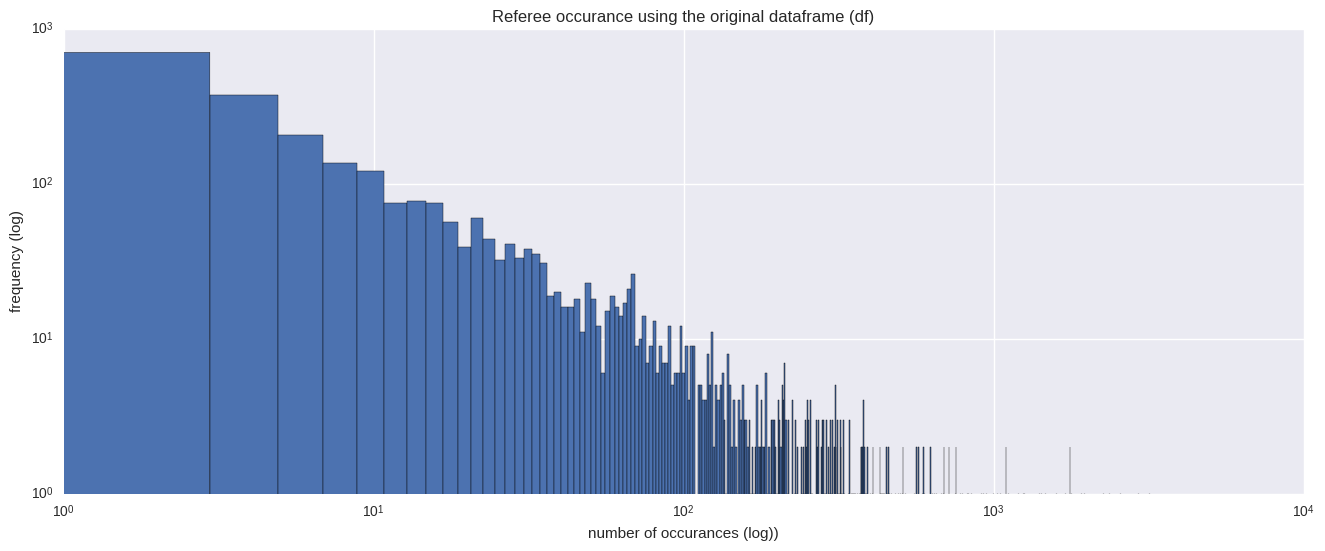

In [14]:
plt.hist(df[["refNum", "games"]].groupby("refNum").sum().games.tolist(), referee_b-11)
plt.xscale('log')
plt.xlabel('number of occurances (log))')
plt.yscale('log')
plt.ylabel('frequency (log)')
plt.title("Referee occurance using the original dataframe (df)")
plt.show()

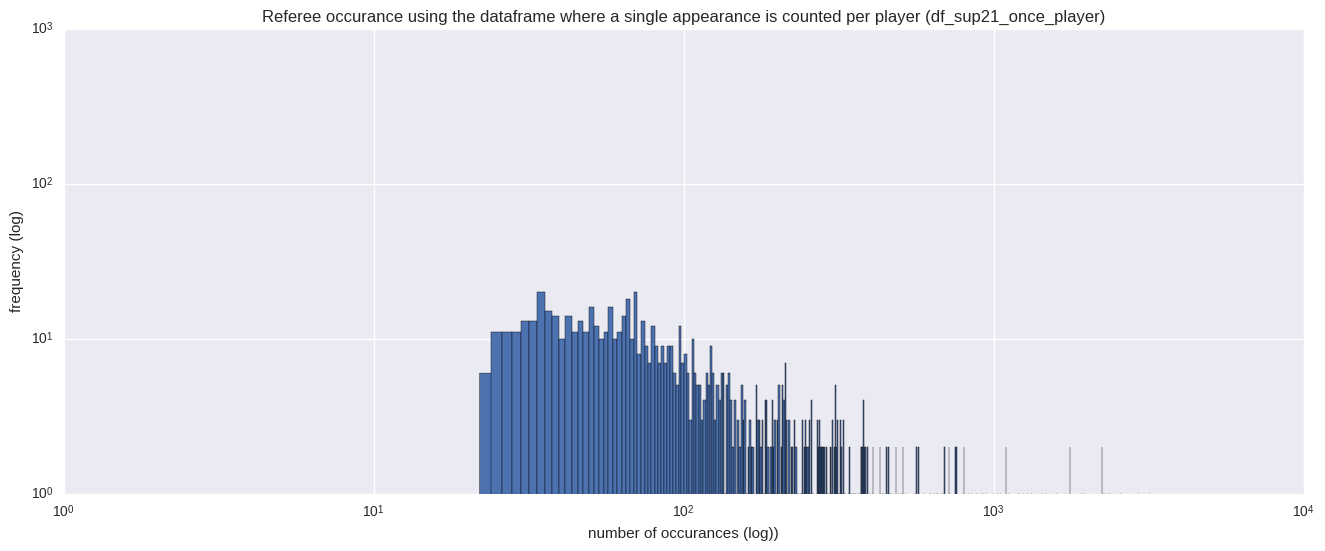

In [15]:
plt.hist(df_sup21_once_player[["refNum", "games"]].groupby("refNum").sum().games.tolist(), referee_b-11)
plt.xscale('log')
plt.xlim([1,10000])
plt.xlabel('number of occurances (log))')
plt.yscale('log')
plt.ylim([0,1000])
plt.ylabel('frequency (log)')
plt.title("Referee occurance using the dataframe where a single appearance is counted per player (df_sup21_once_player)")
plt.show()

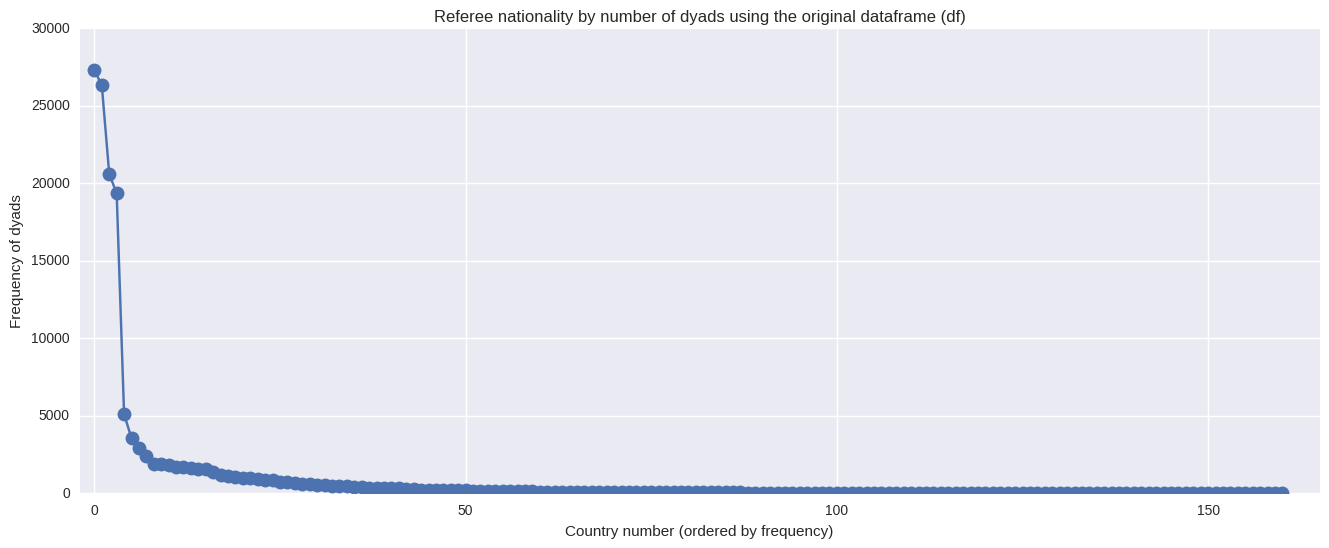

In [16]:
x = df.refCountry.value_counts()
lines = plt.plot(x.values, marker='.', ms=20)
plt.title('Referee nationality by number of dyads using the original dataframe (df)')
plt.xlabel('Country number (ordered by frequency)')
plt.xlim([-2,165])
plt.ylabel('Frequency of dyads')
plt.show()

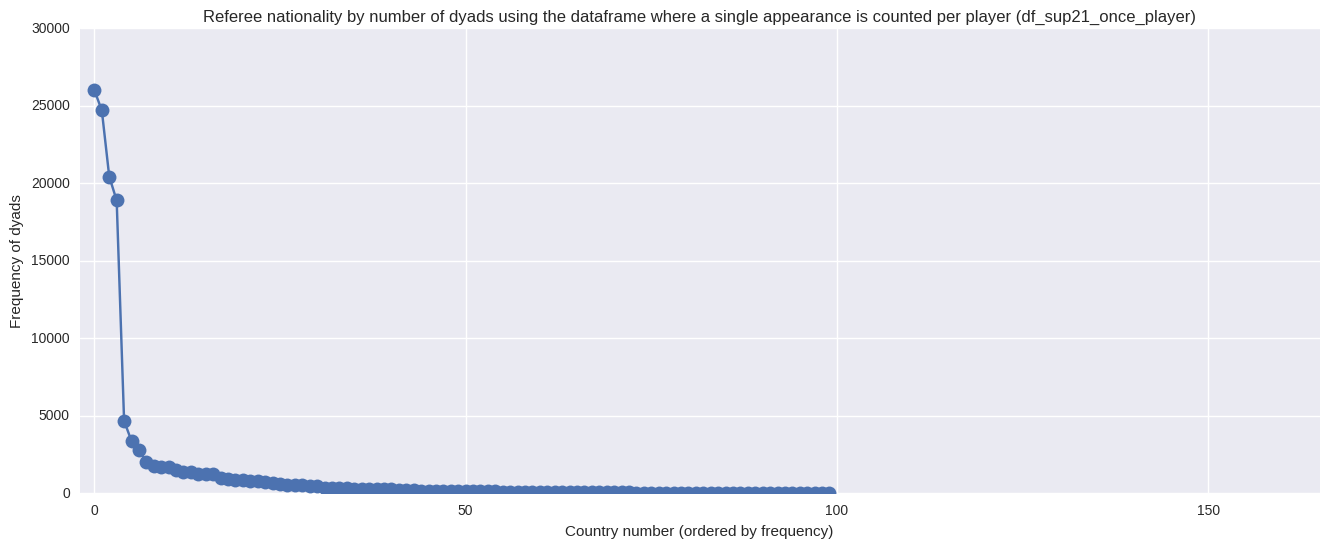

In [17]:
x = df_sup21_once_player.refCountry.value_counts()
lines = plt.plot(x.values, marker='.', ms=20)
plt.title('Referee nationality by number of dyads using the dataframe where a single appearance is counted per player (df_sup21_once_player)')
plt.xlabel('Country number (ordered by frequency)')
plt.xlim([-2,165])
plt.ylabel('Frequency of dyads')
plt.show()

Here we see that our method reduces the number of total countries but doesn't change the frequency of dyads with the most represented countries compared to the previous graph.

## Removing non usable data for our ML algorithm

We know sometimes there is no image for a player and therefore no skin color rating, which is why we remove them.

In [18]:
df_with_pic = df_sup21_once_player[df_sup21_once_player["photoID"].notnull()]

In [19]:
df_sup21_once_player.shape[0]

133501

In [20]:
df_with_pic.shape[0]

113862

Should be all clean now.

In [21]:
dfc = df_with_pic

## Aggregating the data by player

Let's look at a single player's dyads to have an idea of what they look like.

In [22]:
groups = dfc.groupby("playerShort")

In [23]:
lucas = groups.get_group("lucas-wilchez")

In [24]:
lucas.head().ix[:,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
2782,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,3,1,1,1,0
3384,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
5692,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,1,0,0,0
9058,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,2,2,0,0,0
14886,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,1,0,0


In [25]:
lucas.head().ix[:,13:]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
2782,0,0,0,95212.jpg,0.25,0.5,88,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3384,0,0,0,95212.jpg,0.25,0.5,94,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5692,0,0,0,95212.jpg,0.25,0.5,137,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
9058,1,0,0,95212.jpg,0.25,0.5,214,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
14886,0,0,0,95212.jpg,0.25,0.5,313,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696


First we will only keep the columns that seem relevant to us and remove the others :
- `player` which is a repetition of the playershort
- `photoID` which is 1-to-1 with the player
- referee related attibutes which cannot be aggregated (`refNum`, `refCountry`, `Alpha3`)
- `nIAT` and `nExp` really not relevant here we could do a weihted mean with the "mean" and "se" columns but it seemed a bit exagerated (futur improvement ?)
    
Why we kept other columns is explained below with the aggregation operation.

In [26]:
df_byshort = dfc.groupby("playerShort")
df_grouped = df_byshort.agg({
        "club": lambda x: x.unique()[0],
        "leagueCountry": lambda x: x.unique()[0],
        "birthday": lambda x: x.unique()[0],
        "height": np.max,
        "weight": np.max,
        "position": lambda x: x.unique()[0],
        "games": np.sum,
        "victories": np.sum,
        "ties": np.sum,
        "defeats": np.sum,
        "goals": np.sum,
        "yellowCards": np.sum,
        "yellowReds": np.sum,
        "redCards": np.sum,
        "rater1": np.max, # never changes so we can take either min, max or mean 
        "rater2": np.max, # same here (we used this to test that nothing changed : [np.min, np.max, np,mean])
        "meanIAT": np.mean, # Here doing the mean seems a bit confusing but it will give an 
        "seIAT": np.mean,   # indicatiion whether the player could have been mistreated in 
                            # some of his matches or never.
        "meanExp": np.mean, # Same here
        "seExp": np.mean    # We could have applied pooled variance (will see later) : https://en.wikipedia.org/wiki/Pooled_variance
    })

In [27]:
# We used this to check wether min and max rating change for each player (which was not the case)
np.count_nonzero(df_byshort.agg({"rater1": np.min}) != df_byshort.agg({"rater1": np.max}))

0

In [28]:
np.count_nonzero(df_byshort.agg({"rater2": np.min}) != df_byshort.agg({"rater2": np.max}))

0

In [29]:
np.count_nonzero(df_byshort.agg({"position": lambda x: x.unique().shape[0]}) > 1)

0

In [30]:
np.count_nonzero(df_byshort.agg({"leagueCountry": lambda x: x.unique().shape[0]}) > 1)

0

In [31]:
np.count_nonzero(df_byshort.agg({"club": lambda x: x.unique().shape[0]}) > 1)

0

In [32]:
np.count_nonzero(df_byshort.agg({"birthday": lambda x: x.unique().shape[0]}) > 1)

0

In [33]:
df_grouped.head().ix[:,:13]

,redCards,ties,yellowCards,rater2,birthday,seExp,goals,rater1,defeats,leagueCountry,victories,meanExp,seIAT
playerShort,,,,,,,,,,,,,
aaron-hughes,0,176,19,0.00,08.11.1979,0.001553,9,0.25,222,England,243,0.487879,0.000333
aaron-hunt,1,70,39,0.25,04.09.1986,0.001025,59,0.00,119,Germany,140,0.453989,0.000226
aaron-lennon,0,97,11,0.25,16.04.1987,0.002032,31,0.25,115,England,200,0.491482,0.000367
aaron-ramsey,1,42,31,0.00,26.12.1990,0.002938,39,0.00,67,England,145,0.511650,0.000525
abdelhamid-el-kaoutari,2,40,8,0.25,17.03.1990,0.005296,1,0.25,43,France,41,0.335587,0.001488


In [34]:
df_grouped.head().ix[:,13:]

,weight,height,meanIAT,club,games,yellowReds,position
playerShort,,,,,,,
aaron-hughes,71.0,182.0,0.344759,Fulham FC,641,0,Center Back
aaron-hunt,73.0,183.0,0.349332,Werder Bremen,329,0,Attacking Midfielder
aaron-lennon,63.0,165.0,0.345893,Tottenham Hotspur,412,0,Right Midfielder
aaron-ramsey,76.0,178.0,0.346790,Arsenal FC,254,0,Center Midfielder
abdelhamid-el-kaoutari,73.0,180.0,0.331600,Montpellier HSC,124,4,Center Back


In [35]:
len(df_grouped)

1584

Thanks to the description of the data in DATA.md we know there should be 1586 players with pictures.
With this value we can validate the fact that we lost minimal data and have most of the players with a picture.

## Preparing Data

As a last step before starting to do machine learning we need to reformat the data and seperate it

First we need to make rows which contain strings in integers (club, position, leagueCountry)

In [36]:
df_grouped["club"] = df_grouped["club"].astype(np.str)
df_grouped["position"] = df_grouped["position"].astype(np.str)
df_grouped["leagueCountry"] = df_grouped["leagueCountry"].astype(np.str)

def encodeLabels(col, df):
    le = LabelEncoder()
    le.fit(df[col].unique())
    df[col] = le.transform(df[col])

encodeLabels("club", df_grouped)
encodeLabels("position", df_grouped)
encodeLabels("leagueCountry", df_grouped)

In [37]:
today = datetime.datetime.now()
df_grouped.birthday = df_grouped.birthday.apply(lambda x : float((today - pd.to_datetime(x)).days))

Now we can create the futur x and y for training

In [38]:
y_possible = df_grouped[["rater1","rater2"]]
y_possible.head()

,rater1,rater2
playerShort,,
aaron-hughes,0.25,0.00
aaron-hunt,0.00,0.25
aaron-lennon,0.25,0.25
aaron-ramsey,0.00,0.00
abdelhamid-el-kaoutari,0.25,0.25


In [39]:
x = df_grouped.drop(y_possible, axis=1)
x.head().ix[:,:13]

,redCards,ties,yellowCards,birthday,seExp,goals,defeats,leagueCountry,victories,meanExp,seIAT,weight,height
playerShort,,,,,,,,,,,,,
aaron-hughes,0,176,19,13620.0,0.001553,9,222,0,243,0.487879,0.000333,71.0,182.0
aaron-hunt,1,70,39,11187.0,0.001025,59,119,2,140,0.453989,0.000226,73.0,183.0
aaron-lennon,0,97,11,10815.0,0.002032,31,115,0,200,0.491482,0.000367,63.0,165.0
aaron-ramsey,1,42,31,9465.0,0.002938,39,67,0,145,0.511650,0.000525,76.0,178.0
abdelhamid-el-kaoutari,2,40,8,9749.0,0.005296,1,43,1,41,0.335587,0.001488,73.0,180.0


In [40]:
x.head().ix[:,13:]

,meanIAT,club,games,yellowReds,position
playerShort,,,,,
aaron-hughes,0.344759,34,641,0,1
aaron-hunt,0.349332,90,329,0,0
aaron-lennon,0.345893,82,412,0,10
aaron-ramsey,0.346790,6,254,0,3
abdelhamid-el-kaoutari,0.331600,51,124,4,1


In [41]:
for feature, col in x.iteritems():
        has_nan = True in col.isnull().unique()
        if has_nan:
            x[feature] = col.fillna(int(col.mean()))

## Naive machine learning

In [42]:
rfc = RFC(n_estimators=10, n_jobs=-1, class_weight=None)

Let's build y (in a naive fashion for now) and use sklearn normalizer with the y's.

In [43]:
y = ((y_possible['rater1'] + y_possible['rater2']) / 2 < 0.5).values

In [44]:
normalizer = Normalizer()
for feature, col in x.iteritems():
    x[feature] = normalizer.fit_transform(col.reshape(-1,len(col)), y).T

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


In [45]:
rfc.fit(x, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [46]:
y_pred = rfc.predict(x)

In [47]:
print(metrics.mean_absolute_error(y, y_pred))
print(metrics.accuracy_score(y, y_pred))

0.0107323232323
0.989267676768


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/regression.py:164: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average(np.abs(y_pred - y_true),


Overfitting seems to be high without validating.

## Correct validation

Let's first split the dataset into a training and testing set. This seems to be generally a good practice in machine learning :).

In [48]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [49]:
rfc = RFC(n_estimators=10, class_weight=None)

In [50]:
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [51]:
y_pred = rfc.predict(x_test)

In [52]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

0.246056782334
0.753943217666


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/regression.py:164: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
  output_errors = np.average(np.abs(y_pred - y_true),


Ok that's kind of disapointing... (but not so much suprising). A better way to show the error is cross validation.

In [53]:
# Cross validation 10-Fold (for now) with accuracy scoring
scores = cross_val_score(rfc, x, y, cv=10, scoring='accuracy')

In [54]:
def show_score(scores):
    print(scores)
    print("--------------------------")
    print("mean :", np.mean(scores))
    print("min :", np.min(scores))
    print("max :", np.max(scores))

show_score(scores)

[ 0.75471698  0.78616352  0.70440252  0.72955975  0.75471698  0.78481013
  0.75316456  0.77848101  0.79746835  0.78980892]
--------------------------
mean : 0.763329271626
min : 0.704402515723
max : 0.79746835443


We can see again that the result is not pretty, the mean result we have is ~76% which is not much better than predicting that all players are light skinned.

Proportions of classes for the mean rating (considering 1 -> $mean \leq 0.5$).

In [55]:
# Proportion of light and dark skinned players
prop_1 = np.sum(y) / len(y)
prop_0 = 1 - prop_1
print("proportion of ones :", prop_1)
print("proportion of zeroes :", prop_0)

proportion of ones : 0.756944444444
proportion of zeroes : 0.243055555556


Let's look at what the confusion matrix has to say.

In [56]:
confusion_mx = metrics.confusion_matrix(y_test, y_pred)
TP = confusion_mx[1, 1]
TN = confusion_mx[0, 0]
FP = confusion_mx[0, 1]
FN = confusion_mx[1, 0]

In [57]:
confusion_mx

array([[ 27,  49],
       [ 29, 212]])

Depending on the tree we got approximatively:

|total : 317| pred : 0 |  pred : 1  |
|---|----|-----|
| actual : 0 | TN = 24 | FP = 52 |
| actual : 1 | FN = 25 | TP = 216 |

We can see here that we are good at predicting 1s, but our predictions of 0s are all over the place.

There is an easy way to show this : the **Specificity** (or how correct is the classifier with 0 values)

In [58]:
specificity = TN / float(TN + FP)
print("Specificity :", specificity)

## cross validation version.
def specificity(y, y_pred, **kwargs):
    confusion_mx = metrics.confusion_matrix(y, y_pred)
    TP = confusion_mx[1, 1]
    TN = confusion_mx[0, 0]
    FP = confusion_mx[0, 1]
    FN = confusion_mx[1, 0]
    
    specificity = TN / float(TN + FP)
    return specificity

specificity_scorer = metrics.make_scorer(specificity)

specificity = cross_val_score(rfc, x, y, cv=20, scoring=specificity_scorer)
print("Cross validated specificity :", np.mean(specificity))

Specificity : 0.355263157895
Cross validated specificity : 0.401447368421


We can compare it to **Sensitivity** (or true positive rate)

In [59]:
sensitivity = TP / float(TP + FN)
print("Sensitivity :", sensitivity)

## cross validation version
recall = cross_val_score(rfc, x, y, cv=20, scoring='recall')
print("Cross validated sensitivity or recall :", np.mean(recall))

Sensitivity : 0.879668049793
Cross validated sensitivity or recall : 0.888262711864


Which is much better. 

All these methods are taken from the course and inspired from this [notebook](http://nbviewer.jupyter.org/github/justmarkham/scikit-learn-videos/blob/master/09_classification_metrics.ipynb).

So, how are we going to do a better job ?

The first thing we realize is that there is a way to indicate to the random forest classifier that there is a disparity within the data.

In [60]:
class_weights = {
    1 : prop_1,
    0 : prop_0
}

In [61]:
rfc = RFC(n_estimators=10, n_jobs=-1, class_weight=class_weights)

We will use a function that prints out most of the information we used above to test our new rfc 

In [62]:
from helpers import test_rfc
test_rfc(rfc, x, y)

Cross validation scores
[ 0.725       0.825       0.775       0.7625      0.7375      0.78481013
  0.65822785  0.73417722  0.73417722  0.73417722  0.74683544  0.79746835
  0.72151899  0.84810127  0.72151899  0.73417722  0.78481013  0.87341772
  0.78481013  0.76923077]
--------------------------
cross mean : 0.762622930867
cross min : 0.658227848101
cross max : 0.873417721519
----------
TP : 210
TN : 30
FP : 46
FN : 31
----------
specificity : 0.381184210526
sensitivity or recall : 0.86738700565


Ok, too bad it's not really an improvement.

Let's try something else : changing the classification threshold

We think this will help the **specificity** get higher.

Let's retrain our data with our new rfc (with weights)

In [63]:
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

Getting the probability of ones of the classifier

In [64]:
y_pred_prob = rfc.predict_proba(x_test)[:, 1]

Separating the probability of true and false values

In [65]:
y_pred_prob1 = [x[1] for x in zip(y_test, y_pred_prob) if x[0]]
y_pred_prob0 = [x[1] for x in zip(y_test, y_pred_prob) if not x[0]]

The following graph was inspired by this video :

https://www.youtube.com/watch?v=OAl6eAyP-yo

It shows in blue the probability given to the true 0 values and in red the probability of true 1 values.

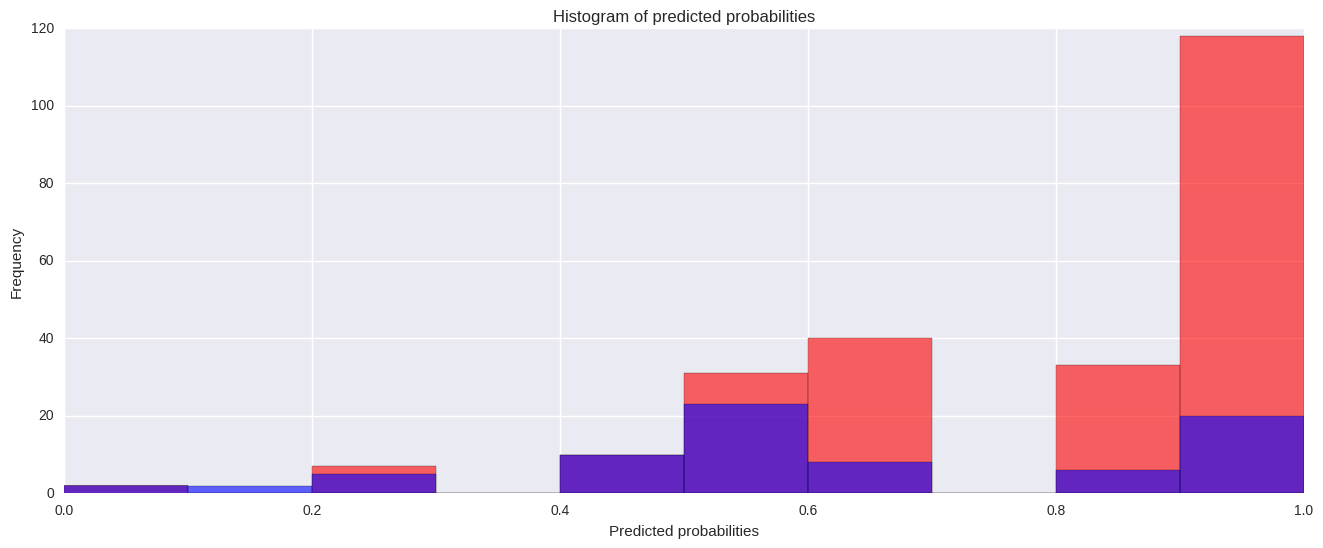

In [66]:
# histogram of predicted probabilities
plt.hist(y_pred_prob1, bins=10, alpha=0.6, color="red")
plt.hist(y_pred_prob0, bins=10, alpha=0.6, color="blue")
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probabilities')
plt.ylabel('Frequency')

With this graph we realized that it's going to be very difficult to have a good and fair model(in terms of specificity and sensitivity) 

To verify this fact we are going to use the ROC curve and the AUC (Area Under the Curve) metric

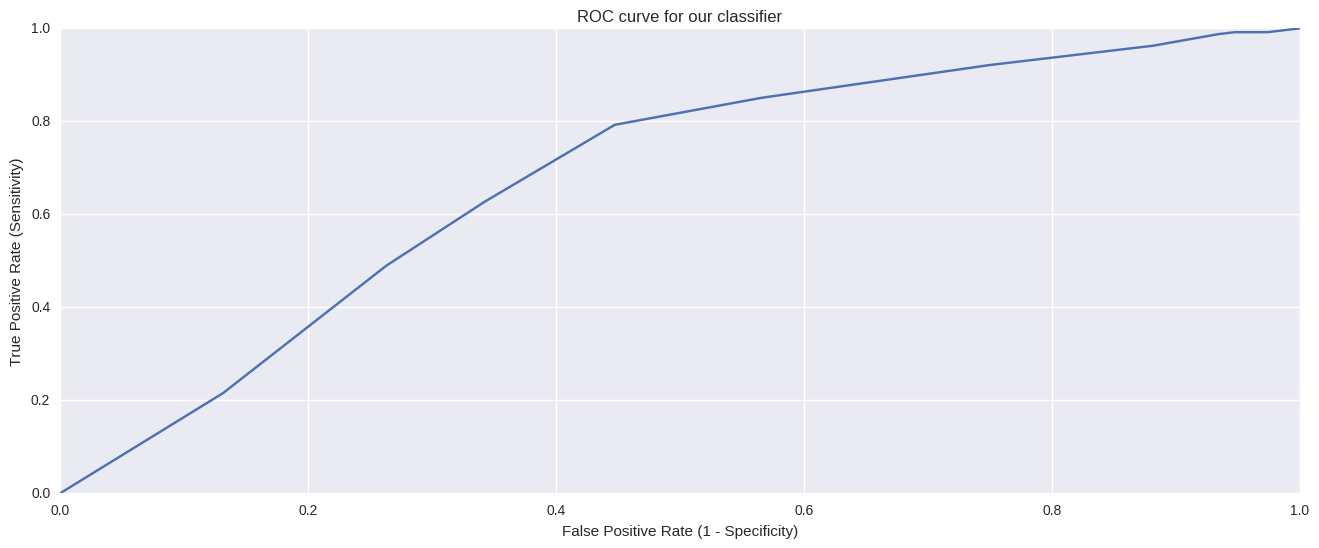

In [67]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.title('ROC curve for our classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

In [68]:
# calculate cross-validated AUC score
AUC_mean = cross_val_score(rfc, x, y, cv=10, scoring='roc_auc').mean()
print("AUC score :", AUC_mean)

AUC score : 0.690257948321


Ok, so what does this all mean.

First the ROC curve shows us what are the best compromises we can make between Specificity and Sensitivity (be aware that here specificity is inversed), with that you could chose precisely what you want the classifier to be compromising.

For the AUC score it shows a score of our model compared to a random sampling of 1's and 0's. (NB: the random sample is weighted of course)

Ok now we have all the tools to try and accuratly validate a method

computing cross validation for accuracy
Cross validation scores
[ 0.7375      0.7875      0.7125      0.8125      0.7125      0.79746835
  0.64556962  0.7721519   0.79746835  0.70886076  0.70886076  0.83544304
  0.69620253  0.78481013  0.69620253  0.81012658  0.69620253  0.84810127
  0.81012658  0.75641026]
--------------------------
cross mean : 0.756325259656
cross min : 0.645569620253
cross max : 0.848101265823
computing confusion matrix
----------
TN : 27 FP : 49
FN : 30 TP : 211
----------
computing cross validation for specificity
specificity : 0.422894736842
computing cross validation for recall
sensitivity or recall : 0.858234463277
computing cross validation for precision
precision : 0.815068838877


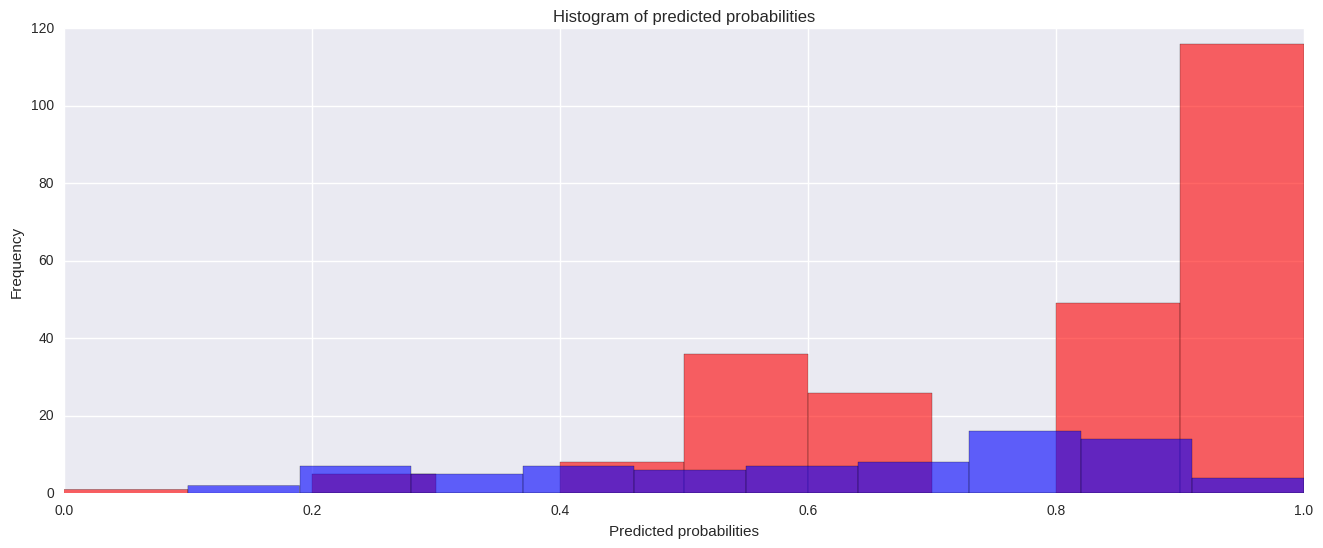

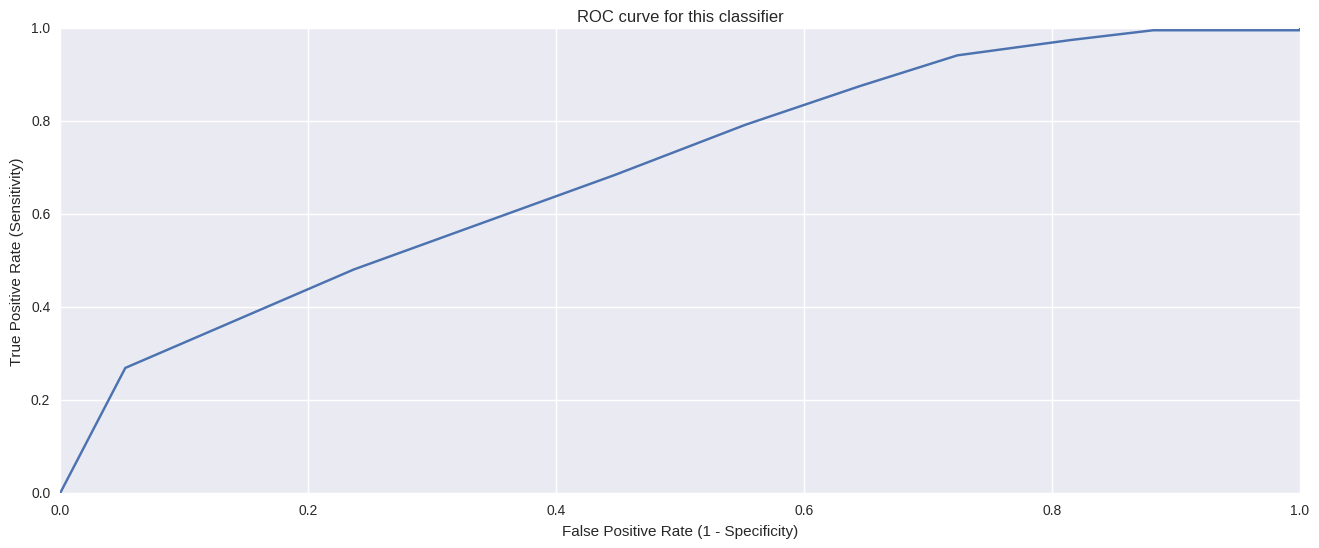

computing cross validation for AUC
AUC score : 0.695487957181
computing cross validation for f1_mean
f1 score : 0.695487957181
computing cross validation for f1_mean
f1 score : 0.695487957181


In [69]:
test_rfc_complete(rfc, x, y)

## Modifying the model

In this part we try to modify our model to have better result.

We have a lot of parameters to test for the random classifier, we selected two of them we think could change the results of the model.
 
The parameters we will test : 
  - n_estimators
  - max_features
  - max_depth

In [70]:
rfc = RFC(n_estimators=10, max_features=None, n_jobs=-1, class_weight=class_weights)

In [71]:
n_estimators_range = list(range(10,40))
max_features_range = uniform()
param_dist = dict(n_estimators=n_estimators_range, 
                  max_features=max_features_range)

In [72]:
rand = RandomizedSearchCV(rfc, param_dist, cv=20, scoring='roc_auc', n_iter=20, random_state=5)
rand.fit(x, y)

RandomizedSearchCV(cv=20, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.24305555555555558, 1: 0.75694444444444442},
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc983defc18>, 'n_estimators': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [73]:
rand.best_params_

{'max_features': 0.29607993273364797, 'n_estimators': 19}

In [74]:
rand.best_score_

0.73578347780511033

After reading a bit more about the classifier (Sklearn doc) apparently sqrt as max_features works best for classification, let's test that and with log2 as we have the option.

In [75]:
rfc = RFC(n_estimators=10, max_features="sqrt", n_jobs=-1, class_weight=class_weights)

In [76]:
n_estimators_range = list(range(20,40))
max_features_range = ["sqrt", "log2"]
max_depth_range = list(range(1, 20))
param_dist = dict(n_estimators=n_estimators_range, 
                  max_features=max_features_range,
                 max_depth=max_depth_range)

In [77]:
rand = RandomizedSearchCV(rfc, param_dist, cv=10, scoring='roc_auc', n_iter=20, random_state=5)
rand.fit(x, y)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.24305555555555558, 1: 0.75694444444444442},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'max_features': ['sqrt', 'log2'], 'n_estimators': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [78]:
#removed as not relevant and screen clutering if you're interested uncomment it
#rand.cv_results_

In [79]:
rand.best_params_

{'max_depth': 11, 'max_features': 'log2', 'n_estimators': 37}

In [80]:
rand.best_score_

0.74114444064134466

In [81]:
max_features_b = rand.best_params_["max_features"]
n_estimators_b = rand.best_params_["n_estimators"]
max_depth_b = rand.best_params_["max_depth"]

computing cross validation for accuracy
Cross validation scores
[ 0.75        0.825       0.8125      0.8375      0.8125      0.78481013
  0.74683544  0.75949367  0.79746835  0.79746835  0.74683544  0.83544304
  0.74683544  0.82278481  0.78481013  0.79746835  0.79746835  0.82278481
  0.7721519   0.80769231]
--------------------------
cross mean : 0.792892526777
cross min : 0.746835443038
cross max : 0.8375
computing confusion matrix
----------
TN : 13 FP : 63
FN : 2 TP : 239
----------
computing cross validation for specificity
specificity : 0.235131578947
computing cross validation for recall
sensitivity or recall : 0.969124293785
computing cross validation for precision
precision : 0.803758065257


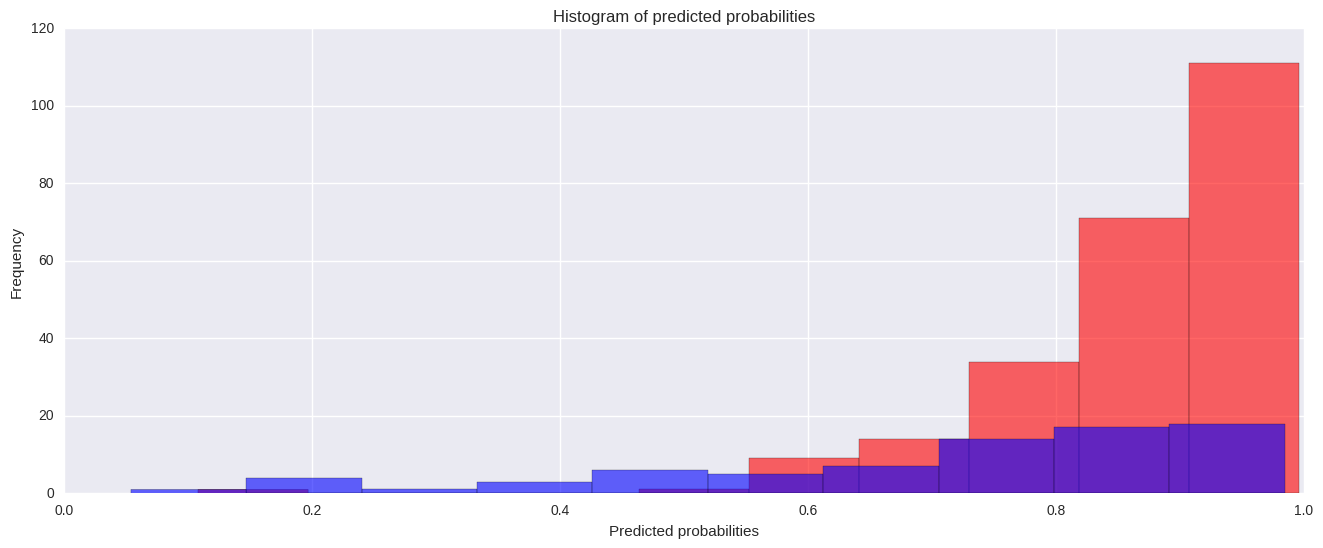

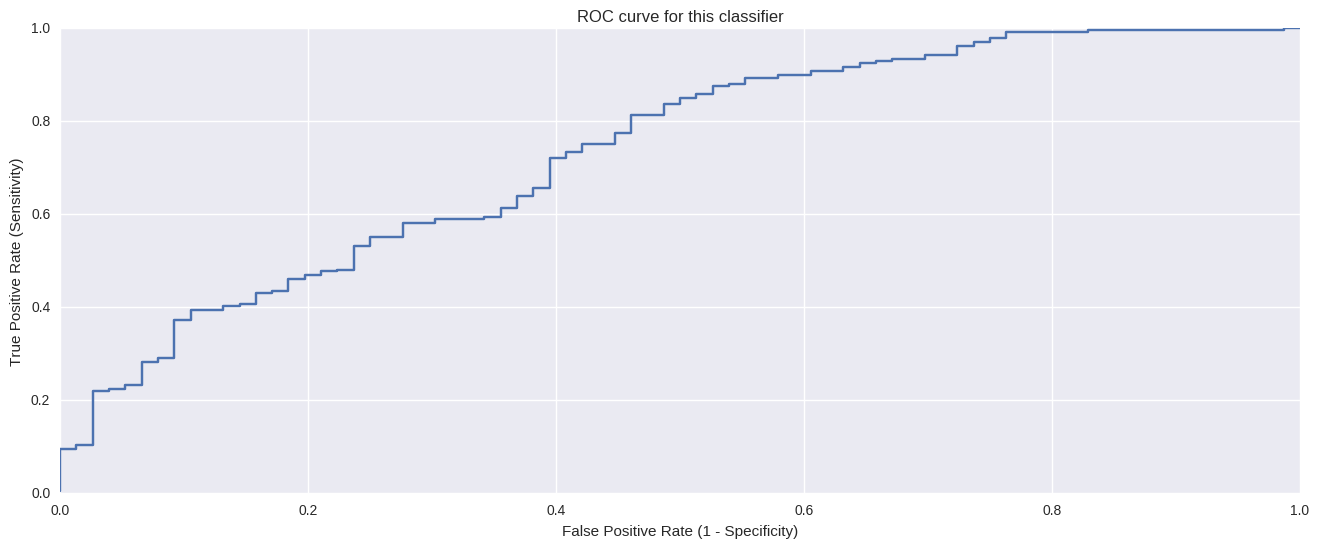

computing cross validation for AUC
AUC score : 0.736180270592
computing cross validation for f1_mean
f1 score : 0.736180270592
computing cross validation for f1_mean
f1 score : 0.736180270592


In [82]:
test_rfc_complete(RFC(max_features=max_features_b, n_estimators=n_estimators_b, max_depth=max_depth_b, n_jobs=-1, class_weight=class_weights), x, y)

We should have with this method the best AUC score. Which is still not really an improvement... (we will reuse this method later) our accuracy got closer to 90% though

## Raters changes

As we said earlier in this notebook there are some things we can tune with the raters data we have. As we know the two raters have the following specificities :
- they rate differently
- they have discrete values [0,0.25,0.5,0.75,1]

There are a few things we want to test : 
- a class for each possible value of the raters
- a class for < 0.5, > 0.5 and 0.5
- an independent learning for both raters
- only keeping the values where rater 1 and 2 are identical

We will test some different mixes below

### A cluster for each value with independent raters

Here we will try predicting the 5 possible classes for one of the raters.

In [83]:
y_1 = (y_possible['rater1']).values

In [84]:
le = LabelEncoder()
le.fit(np.unique(y_1))
y_1 = le.transform(y_1)
y_1

array([1, 0, 1, ..., 3, 0, 0])

In [85]:
x_train, x_test, y_train, y_test = train_test_split(x, y_1, test_size=0.2, random_state=4)

We use the best parameters we found before (they may need a twist later as the model changes)

In [86]:
rfc = RFC(max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1)

In [87]:
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=37, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [88]:
y_pred = rfc.predict(x_test)

In [89]:
scores = cross_val_score(rfc, x, y, cv=20, scoring='accuracy')
show_score(scores)

[ 0.7625      0.825       0.8         0.85        0.75        0.78481013
  0.75949367  0.75949367  0.81012658  0.79746835  0.74683544  0.84810127
  0.72151899  0.82278481  0.73417722  0.79746835  0.79746835  0.86075949
  0.7721519   0.76923077]
--------------------------
mean : 0.788469449854
min : 0.721518987342
max : 0.860759493671


For this method we decided to not go further as it is difficultly testable and the following method gave kind of similar results

We will not make an emphasis on this but here is the confusion matrix.

In [90]:
metrics.confusion_matrix(y_pred=y_pred, y_true=y_test)

array([[88, 35,  2,  1,  0],
       [62, 40,  3,  1,  1],
       [19, 19,  1,  3,  0],
       [12,  9,  0,  3,  5],
       [ 6,  5,  0,  2,  0]])

### 3 classes for values with a twist on the raters values

Let's look a bit more at the raters :

In [91]:
diff = [x[0] - x[1] for x in zip((y_possible['rater2']).values,(y_possible['rater1']).values) if not x[0] == x[1]]

In [92]:
diff = np.abs(diff)

In [93]:
np.unique(diff, return_counts=True)

(array([ 0.25,  0.5 ]), array([377,   2]))

We can see above that there are only small differences and 2 times where the difference is 0.5

With that we thought of doing this :
 - each time both raters are under 0.5 we put it in group 0
 - each time both raters are above 0.5 we put it in group 1
 - each time one rater is at 0.5 we look if the other falls in 0 or 1 and select that value
 - if both rating are 0.5 we put it in group 2
 - if both rating are between < 0.5 and > 0.5 we put it in group 3 

In [94]:
y_2 = []
for rate1, rate2 in zip((y_possible['rater2']).values,(y_possible['rater1']).values):
    if ((rate1 <= 0.5 and rate2 < 0.5) or (rate1 < 0.5 and rate2 <= 0.5)):
        y_2.append(1)
    elif ((rate1 >= 0.5 and rate2 > 0.5) or (rate1 > 0.5 and rate2 >= 0.5)):
        y_2.append(0)
    elif (rate1 == 0.5 or rate2 == 0.5):
        y_2.append(2)
    else :
        y_2.append(3)

In [95]:
np.unique(y_2, return_counts=True)

(array([0, 1, 2]), array([ 269, 1199,  116]))

We see here that the third group actually is never selected.

In [96]:
x_train, x_test, y_train, y_test = train_test_split(x, y_2, test_size=0.2, random_state=4)

We use the best parameters we found before.

In [97]:
rfc = RFC(max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1)

In [98]:
scores = cross_val_score(rfc, x, y, cv=10, scoring='accuracy')
show_score(scores)

[ 0.80503145  0.80503145  0.76100629  0.77358491  0.80503145  0.79746835
  0.79113924  0.79113924  0.80379747  0.80254777]
--------------------------
mean : 0.793577760909
min : 0.761006289308
max : 0.805031446541


Here accuracy has not changed from before. Let's look at the confusion matrix.

In [99]:
# Prep of training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y_2, test_size=0.2, random_state=4)

In [100]:
# Do prediction for test values
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

In [101]:
# Let's compute the convolution matrix
confusion_mx = metrics.confusion_matrix(y_test, y_pred)
confusion_mx

array([[ 15,  34,   1],
       [  7, 234,   0],
       [  1,  24,   1]])

With the confusion matrix, the first problem we see is that their was **no prediction for the class 2**. The second is that there is a lot of false positives and the actual sensitivity is :

In [102]:
confusion_mx[1,1] / (confusion_mx[0,1]  + confusion_mx[1,1] +confusion_mx[2,1])

0.80136986301369861

Which is worse than what we had before.

### Last solution, change the threshold position

The intuition for this change is that we know our classifier is better at predicting "lighter" players, therefore increasing the considered "light" players we should get better results in terms of accuracy. 

In [103]:
y_3 = ((y_possible['rater1'] + y_possible['rater2']) / 2 <= 0.5).values

In [104]:
x_train, x_test, y_train, y_test = train_test_split(x, y_3, test_size=0.2, random_state=4)

We know this is the best result we have, so let's find the best parameters we can.

In [105]:
prop1 = np.sum(y_3) / len(y_3)
prop0 = 1 - prop1
class_weights = {
    0 : prop0,
    1 : prop1
}

In [106]:
prop1

0.83017676767676762

In [107]:
rfc = RFC(n_estimators=10, max_features="sqrt", n_jobs=-1, class_weight=class_weights)

In [108]:
n_estimators_range = list(range(20,40))
max_features_range = ["sqrt", "log2"]
max_depth_range = list(range(1, 20))
param_dist = dict(n_estimators=n_estimators_range, 
                  max_features=max_features_range,
                 max_depth=max_depth_range)

In [109]:
rand = RandomizedSearchCV(rfc, param_dist, cv=20, scoring='roc_auc', n_iter=20, random_state=5)
rand.fit(x, y_3)

RandomizedSearchCV(cv=20, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True,
            class_weight={0: 0.16982323232323238, 1: 0.83017676767676762},
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'max_features': ['sqrt', 'log2'], 'n_estimators': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]},
          pre_dispatch='2*n_jobs', random_state=5, refit=True,
          return_train_score=True, scoring='roc_auc', verbose=0)

In [110]:
#removed as not relevant and screen clutering if you're interested uncomment it
#rand.cv_results_

In [111]:
rand.best_params_

{'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 25}

In [112]:
rand.best_score_

0.77710460835460848

In [113]:
max_features_b = rand.best_params_["max_features"]
n_estimators_b = rand.best_params_["n_estimators"]
max_depth_b = rand.best_params_["max_depth"]

In [114]:
rfc = RFC(max_depth=max_depth_b, max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1, class_weight=class_weights)

computing cross validation for accuracy
Cross validation scores
[ 0.825       0.85        0.8625      0.8625      0.85        0.85        0.825
  0.8375      0.85        0.86075949  0.82278481  0.87341772  0.83544304
  0.87341772  0.83544304  0.83333333  0.83333333  0.87179487  0.84615385
  0.84615385]
--------------------------
cross mean : 0.847226752678
cross min : 0.822784810127
cross max : 0.873417721519
computing confusion matrix
----------
TN : 3 FP : 47
FN : 1 TP : 266
----------
computing cross validation for specificity
specificity : 0.164285714286
computing cross validation for recall
sensitivity or recall : 0.989370629371
computing cross validation for precision
precision : 0.853477455877


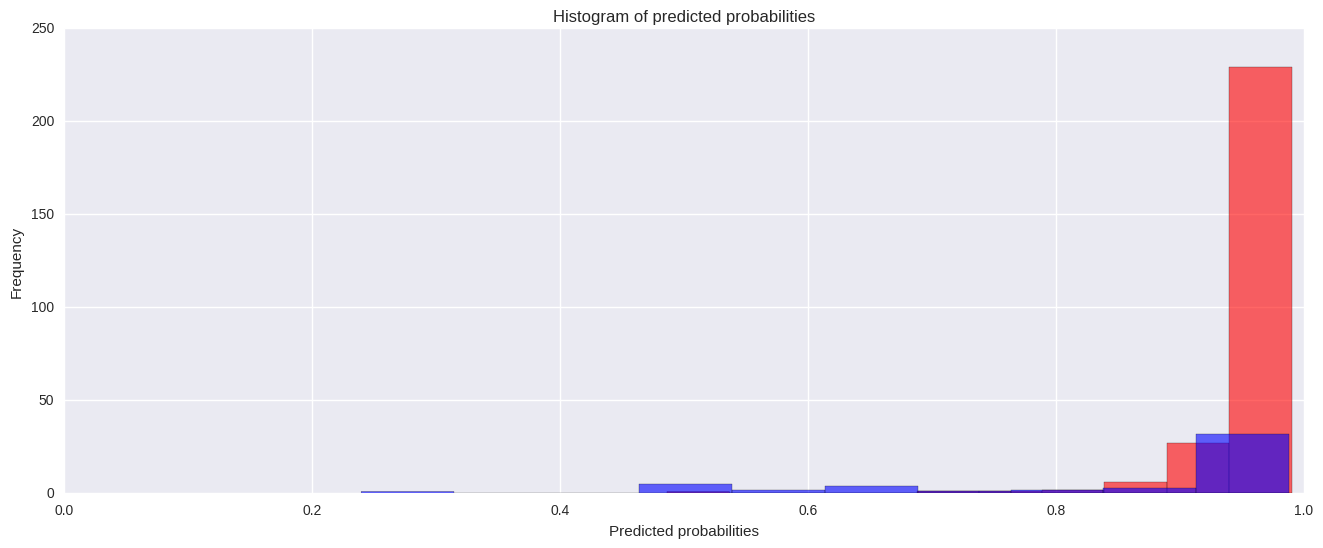

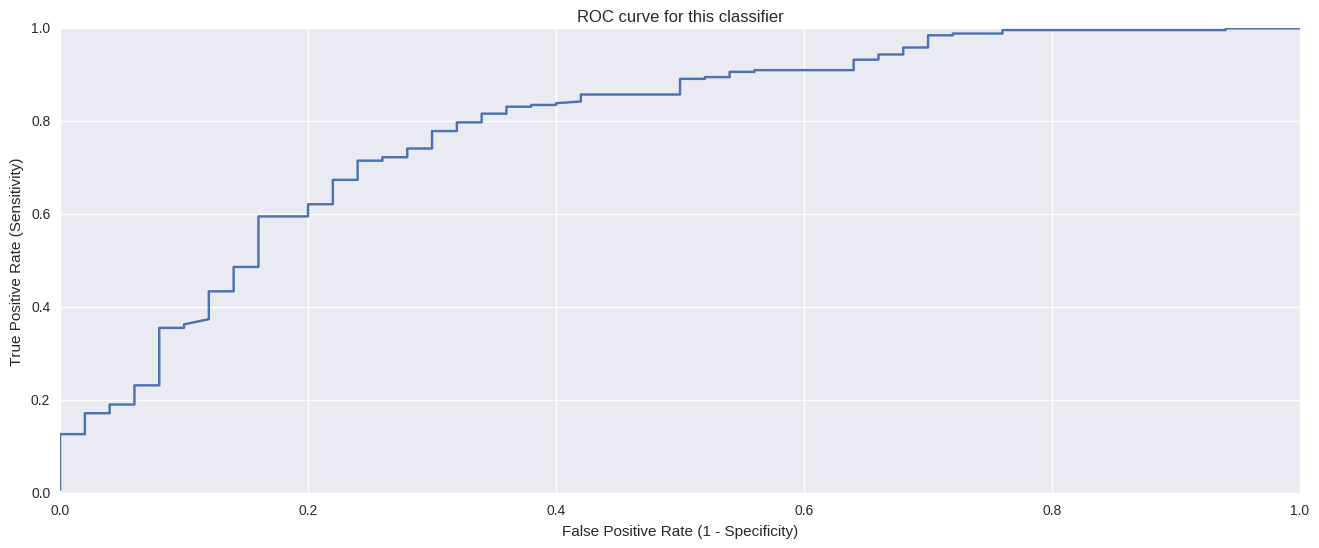

computing cross validation for AUC
AUC score : 0.761555623863
computing cross validation for f1_mean
f1 score : 0.761555623863
computing cross validation for f1_mean
f1 score : 0.761555623863


In [115]:
test_rfc_complete(rfc, x, y_3)

Ok here it is, the best result we had so far. The AUC score is higher than ever before (~77%) ! With an accuracy of 85% we are also above all previously done tests. But if we look at specificity, it's not really better than before. However knowing the AUC score we know we can find a good compromise between the two. 

# Feature importance !

Let's look at the feature importance in our (for now) best classifier.

In [116]:
feature_names = x.columns.values
rfc.fit(x, y)
a = list(zip(feature_names, rfc.feature_importances_))
sorted(a, key=lambda x: -x[1])

[('seIAT', 0.20516634137665662),
 ('seExp', 0.13635441459579339),
 ('meanExp', 0.083404883996817322),
 ('meanIAT', 0.078069588840880416),
 ('leagueCountry', 0.076262115744619663),
 ('yellowCards', 0.064085853447289051),
 ('games', 0.05178303088446775),
 ('birthday', 0.049660319120708257),
 ('goals', 0.035961173926064391),
 ('defeats', 0.034569728897383446),
 ('victories', 0.032066748593849809),
 ('weight', 0.029524407340504585),
 ('ties', 0.029163565210565449),
 ('club', 0.026860105783939173),
 ('height', 0.025719682542413337),
 ('position', 0.01958837363814854),
 ('redCards', 0.013909470193623421),
 ('yellowReds', 0.0078501958662753283)]

We expected the features "league country" and "club" to be important factors. For example some clubs / countries might be more inclined in having lighter players than another.

We surely did not expect the seExp and seMean be a factor if cards were not either. The algorithm could have associated a high meanExp with a lot of cards with a lot of matches with unfair referees, but that doesn't seem to be the case here.

As we don't know why they are so important why don't we remove se\* and mean\*.

In [117]:
x1 = x.drop(["meanExp", "meanIAT", "seIAT", "seExp"], axis=1)

First we need to know how well the classifier does now.

computing cross validation for accuracy
Cross validation scores
[ 0.775       0.7375      0.7625      0.75        0.775       0.75949367
  0.75949367  0.75949367  0.75949367  0.75949367  0.75949367  0.78481013
  0.7721519   0.78481013  0.75949367  0.75949367  0.75949367  0.78481013
  0.75949367  0.76923077]
--------------------------
cross mean : 0.764537487829
cross min : 0.7375
cross max : 0.784810126582
computing confusion matrix
----------
TN : 0 FP : 76
FN : 0 TP : 241
----------
computing cross validation for specificity
specificity : 0.0282894736842
computing cross validation for recall
sensitivity or recall : 0.996666666667
computing cross validation for precision
precision : 0.761559762362


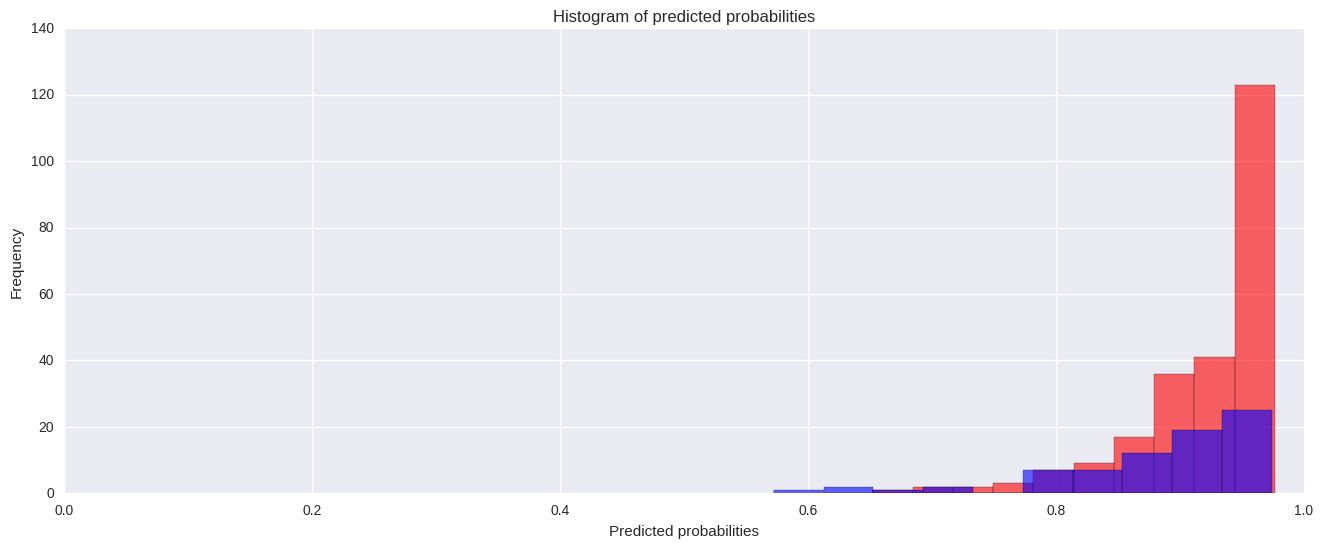

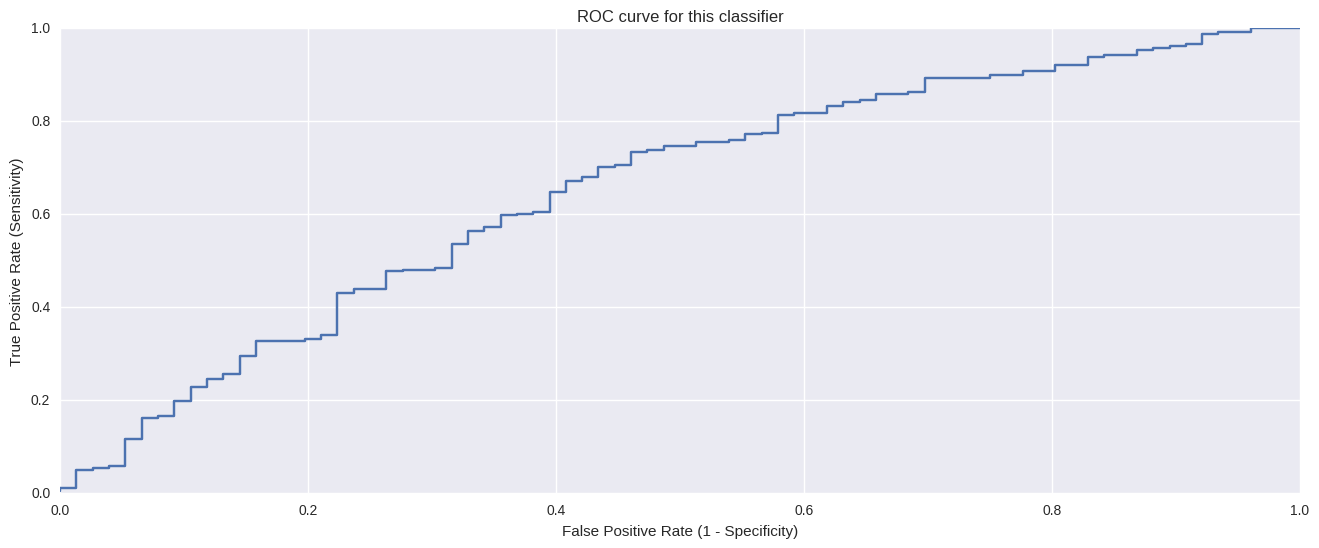

computing cross validation for AUC
AUC score : 0.664311552186
computing cross validation for f1_mean
f1 score : 0.664311552186
computing cross validation for f1_mean
f1 score : 0.664311552186


In [118]:
test_rfc_complete(rfc, x1, y)

As we can see this is a very bad prediction... so they must be important in a way.

In [119]:
feature_names = x1.columns.values
rfc.fit(x1, y)
a = list(zip(feature_names, rfc.feature_importances_))
sorted(a, key=lambda x: -x[1])

[('leagueCountry', 0.16913083721078817),
 ('yellowCards', 0.10496315251599846),
 ('games', 0.100922311514205),
 ('victories', 0.084491897535136987),
 ('defeats', 0.082426709479064483),
 ('goals', 0.077050866920136116),
 ('birthday', 0.07525629580089839),
 ('weight', 0.064033883028816532),
 ('height', 0.063678336304581334),
 ('club', 0.060272455151601144),
 ('ties', 0.053057275746302875),
 ('position', 0.03537875928495441),
 ('yellowReds', 0.016680838178726752),
 ('redCards', 0.012656381328789379)]

Now we will remove some of the worst features, which were certainly adding variance therefore overfitting to our model. If one of our intuition was right (about the cards) we should have a change of feature importance by removing the card information.

In [120]:
x2 = x.drop(["redCards", "yellowReds"], axis=1)

computing cross validation for accuracy
Cross validation scores
[ 0.7875      0.8125      0.825       0.825       0.7875      0.7721519
  0.75949367  0.7721519   0.78481013  0.79746835  0.74683544  0.84810127
  0.75949367  0.84810127  0.78481013  0.81012658  0.79746835  0.81012658
  0.75949367  0.79487179]
--------------------------
cross mean : 0.794150235313
cross min : 0.746835443038
cross max : 0.848101265823
computing confusion matrix
----------
TN : 5 FP : 71
FN : 1 TP : 240
----------
computing cross validation for specificity
specificity : 0.188684210526
computing cross validation for recall
sensitivity or recall : 0.982471751412
computing cross validation for precision
precision : 0.792486806922


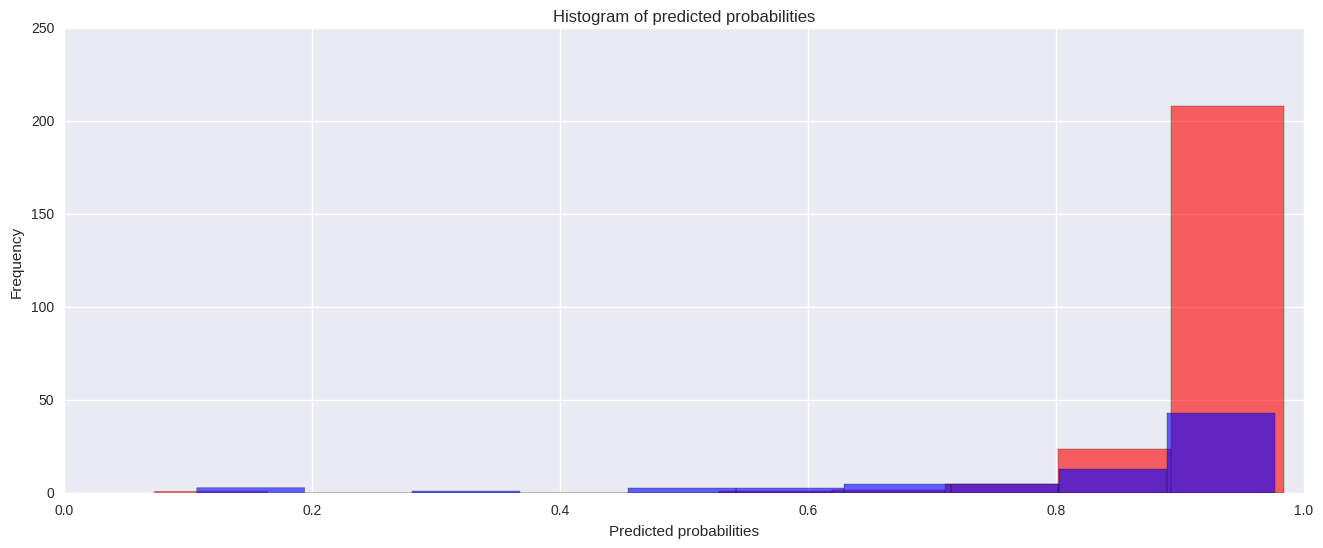

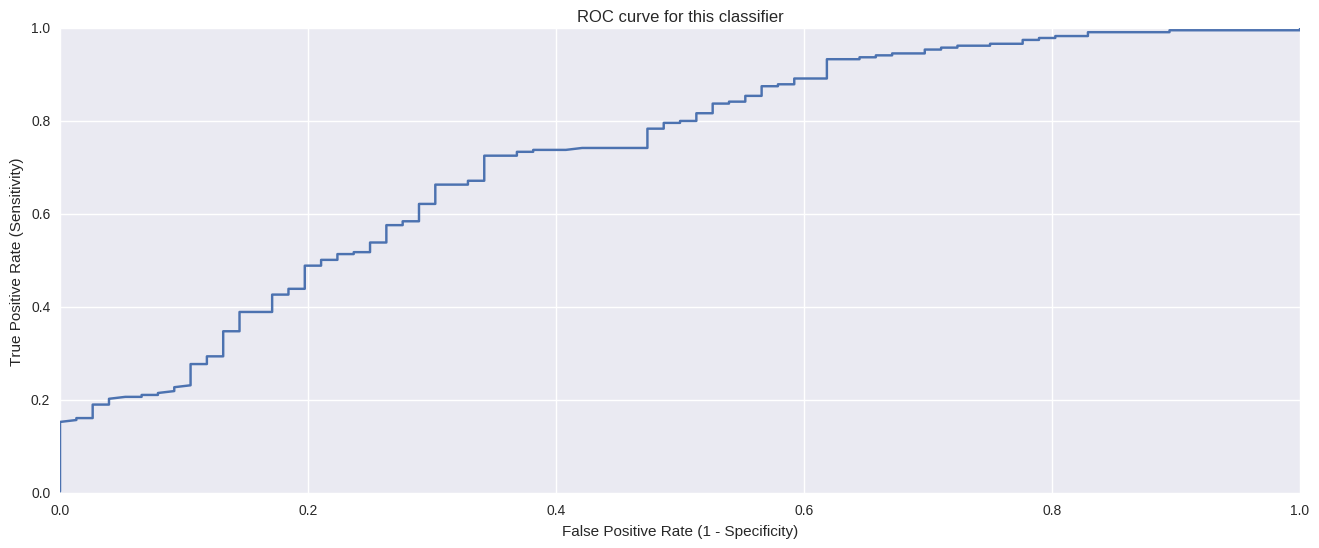

computing cross validation for AUC
AUC score : 0.732705694321
computing cross validation for f1_mean
f1 score : 0.732705694321
computing cross validation for f1_mean
f1 score : 0.732705694321


In [121]:
test_rfc_complete(rfc, x2, y)

This new version of the classifier does a pretty good job with our first y (with 1 = mean(r1,r2) < 0.5)

Let's look at feature importance again :

In [122]:
feature_names = x2.columns.values
rfc.fit(x2, y)
a = list(zip(feature_names, rfc.feature_importances_))
sorted(a, key=lambda x: -x[1])

[('seIAT', 0.18223408893075937),
 ('meanExp', 0.131370537610871),
 ('seExp', 0.12645721547380934),
 ('meanIAT', 0.10573833281919991),
 ('leagueCountry', 0.059011691940773534),
 ('games', 0.054598526605632101),
 ('yellowCards', 0.044273617560533454),
 ('birthday', 0.042922120457920349),
 ('victories', 0.039823177608015542),
 ('weight', 0.03741948823752779),
 ('ties', 0.035826142192587347),
 ('defeats', 0.034801273119025609),
 ('height', 0.027542768769950651),
 ('position', 0.02718303907172576),
 ('goals', 0.026147460909720678),
 ('club', 0.024650518691947548)]

We don't really see a change in the features we wanted to, but one feature clearly dropped down in importance : yellow cards. Weirdly enough what happens next is awesome.

First let's remove one of the less valuable features

In [123]:
x3 = x2.drop(["leagueCountry"], axis=1)

computing cross validation for accuracy
Cross validation scores
[ 0.7625      0.8         0.7875      0.8125      0.775       0.75949367
  0.75949367  0.7721519   0.7721519   0.79746835  0.74683544  0.83544304
  0.75949367  0.81012658  0.78481013  0.81012658  0.79746835  0.82278481
  0.75949367  0.79487179]
--------------------------
cross mean : 0.785985678351
cross min : 0.746835443038
cross max : 0.835443037975
computing confusion matrix
----------
TN : 4 FP : 72
FN : 1 TP : 240
----------
computing cross validation for specificity
specificity : 0.152894736842
computing cross validation for recall
sensitivity or recall : 0.982471751412
computing cross validation for precision
precision : 0.785957352996


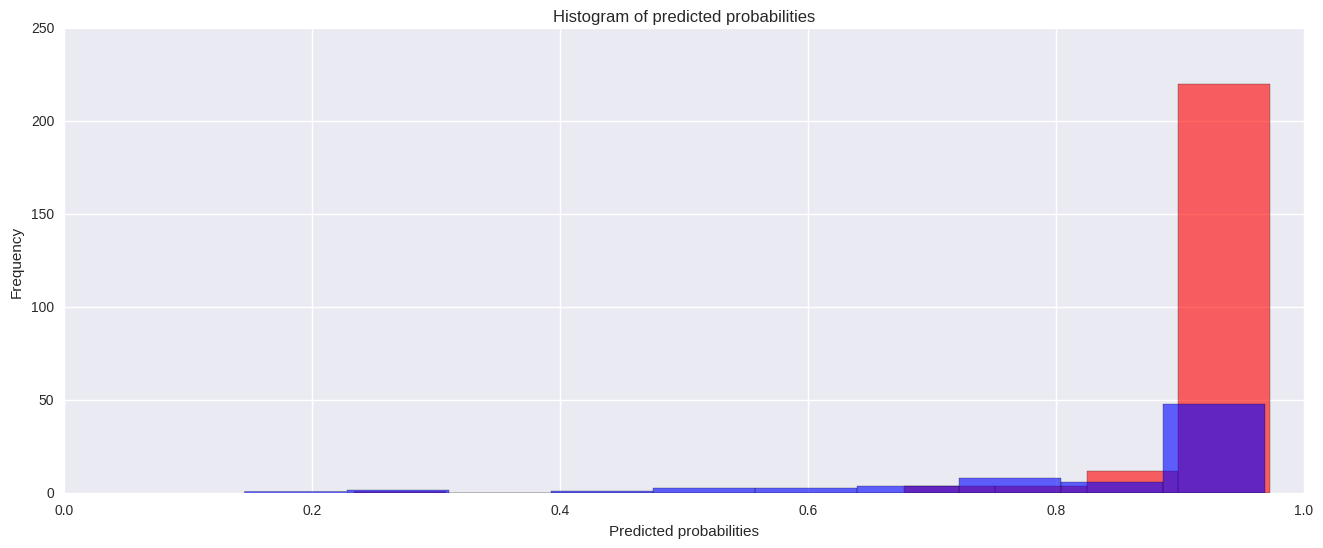

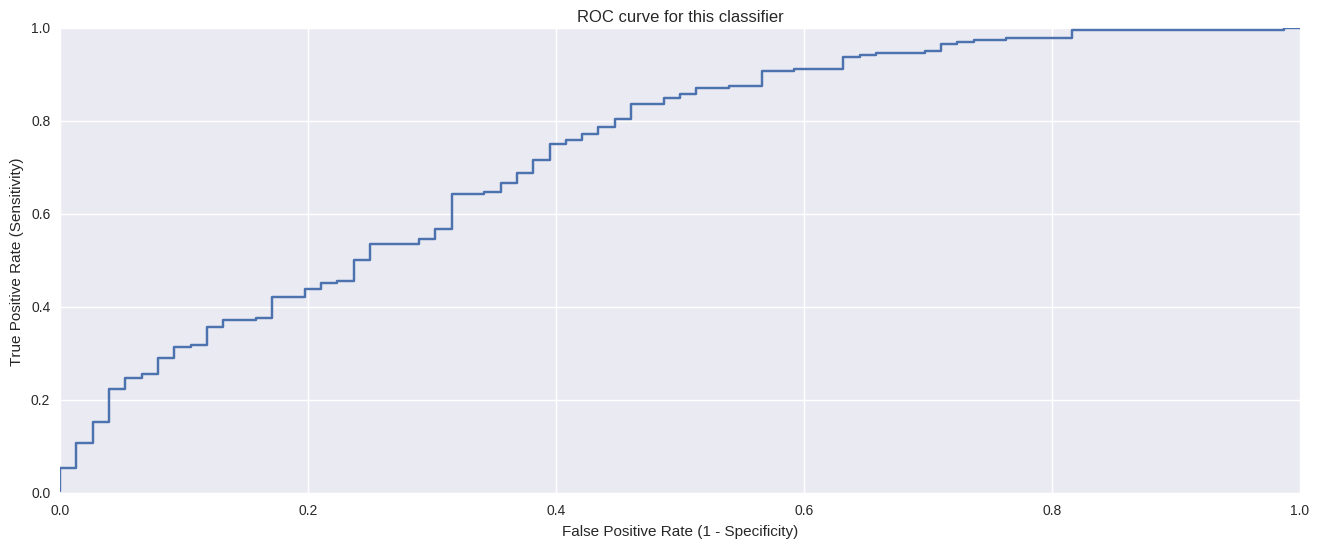

computing cross validation for AUC
AUC score : 0.688209894439
computing cross validation for f1_mean
f1 score : 0.688209894439
computing cross validation for f1_mean
f1 score : 0.688209894439


In [124]:
test_rfc_complete(rfc, x3, y)

we clearly see a drop in AUC and F1 score, now what happens if we remove yellow cards ?

In [125]:
x4 = x2.drop(["yellowCards"], axis=1)

computing cross validation for accuracy
Cross validation scores
[ 0.8         0.7875      0.8         0.8125      0.775       0.75949367
  0.75949367  0.7721519   0.7721519   0.79746835  0.74683544  0.82278481
  0.7721519   0.82278481  0.75949367  0.81012658  0.79746835  0.81012658
  0.75949367  0.78205128]
--------------------------
cross mean : 0.785953829925
cross min : 0.746835443038
cross max : 0.822784810127
computing confusion matrix
----------
TN : 5 FP : 71
FN : 1 TP : 240
----------
computing cross validation for specificity
specificity : 0.157368421053
computing cross validation for recall
sensitivity or recall : 0.987471751412
computing cross validation for precision
precision : 0.786589519327


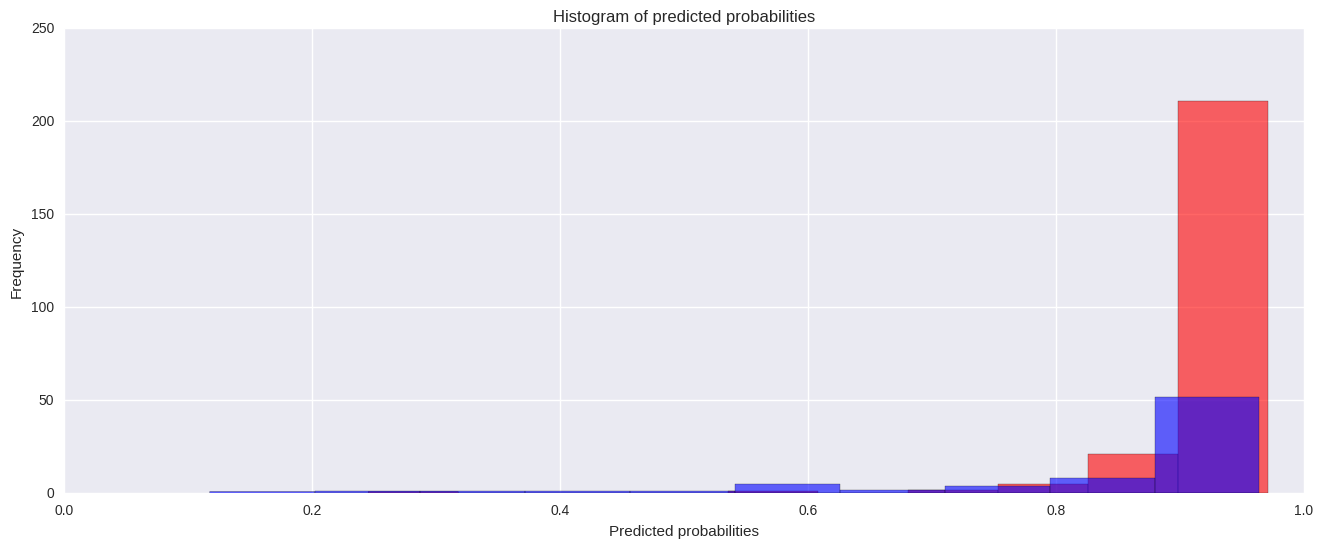

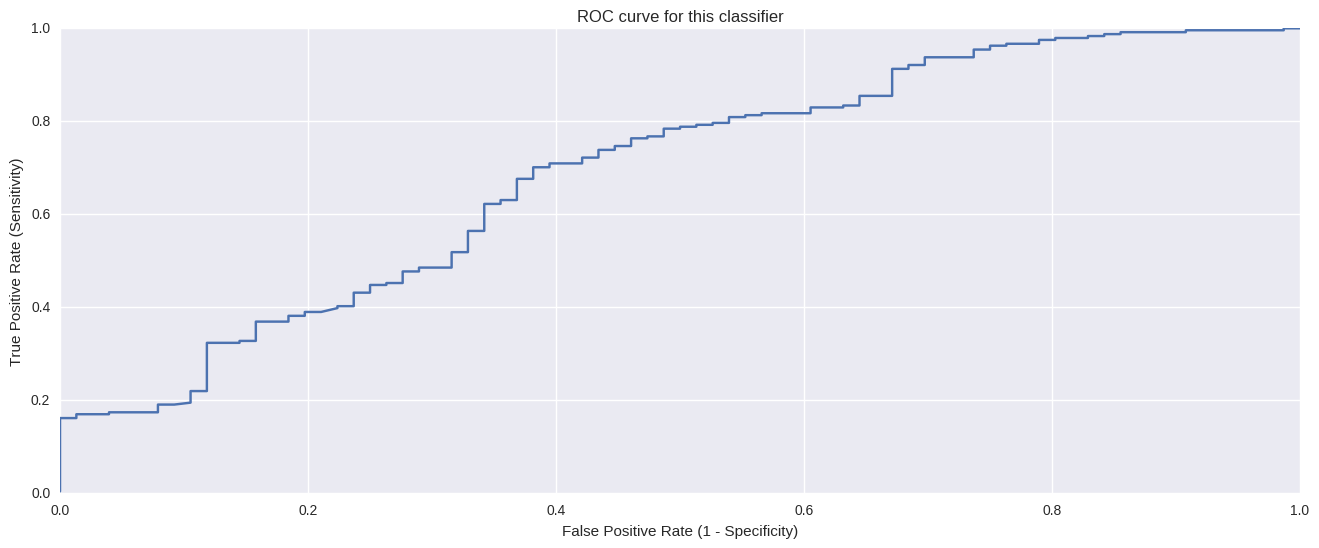

computing cross validation for AUC
AUC score : 0.678892729706
computing cross validation for f1_mean
f1 score : 0.678892729706
computing cross validation for f1_mean
f1 score : 0.678892729706


In [126]:
test_rfc_complete(rfc, x3, y)

As we can see the drop in AUC score is less than the one above ! 

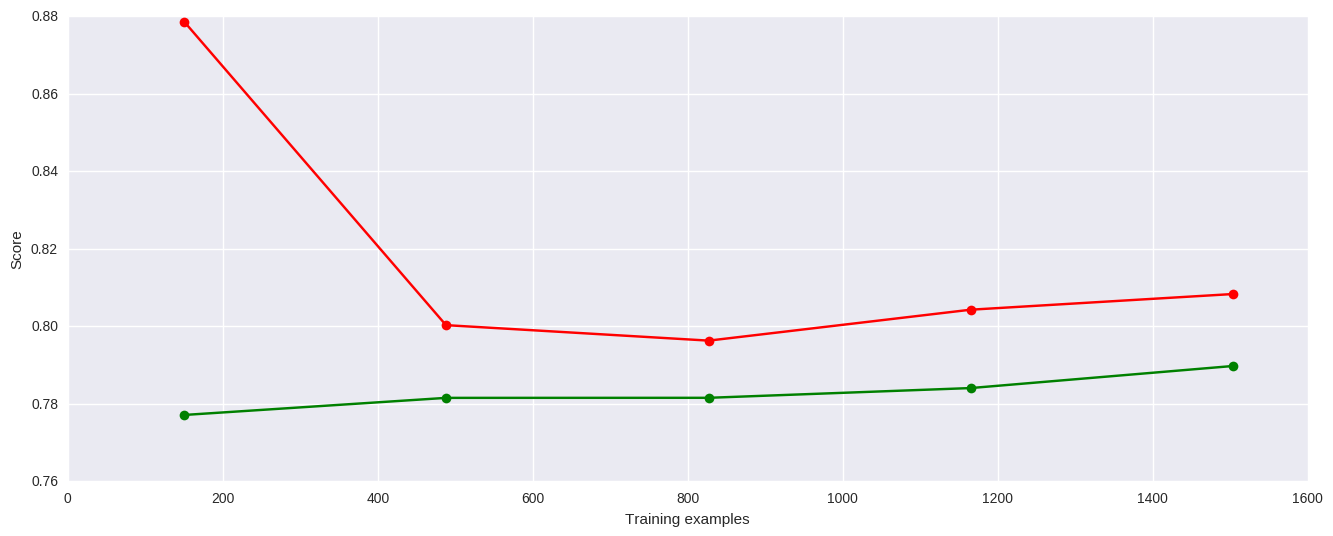

In [127]:
train_sizes, train_scores, test_scores = learning_curve(rfc, x4, y, cv=20, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

# Learning curves ! ( Bonus )

As we were asked let's show the learning curves for our best estimator

In [128]:
y = y_3

In [129]:
rfc = RFC(max_depth=max_depth_b, max_features=max_features_b, n_estimators=n_estimators_b, n_jobs=-1, class_weight=class_weights)

In [130]:
train_sizes, train_scores, test_scores = learning_curve(rfc, x, y, cv=20, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

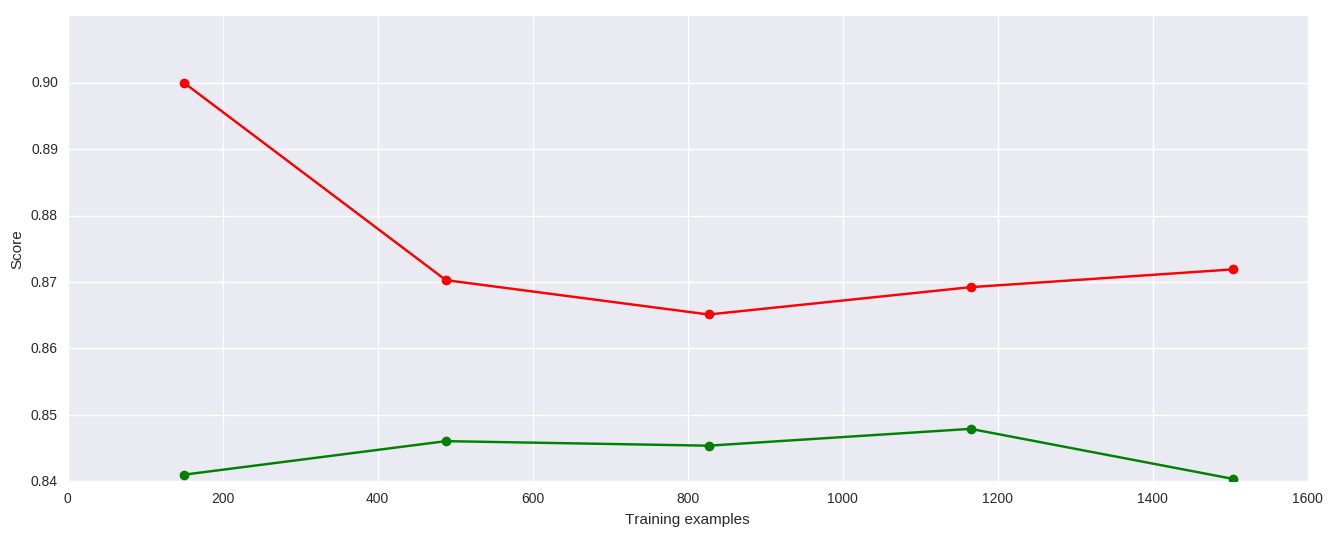

In [131]:
plt.figure()
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

Let's now look at what the change of some parameters does to the curves :

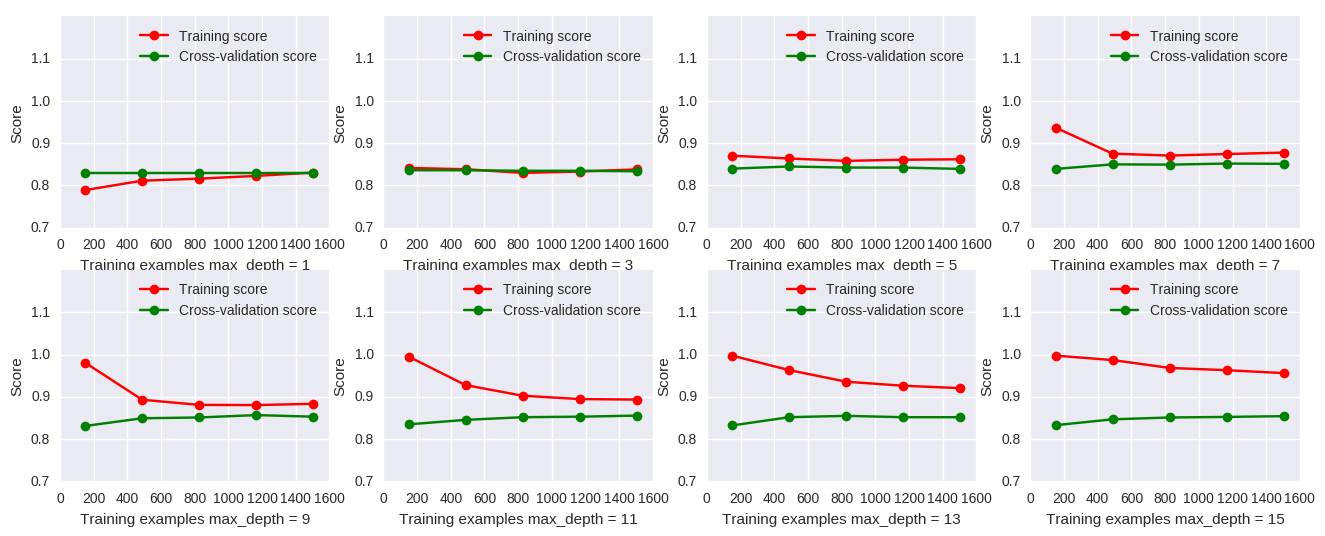

In [132]:
for i,max_depth in enumerate(range(1, 16, 2)):
    rfc = RFC(max_features=max_features_b, n_estimators=n_estimators_b, max_depth=max_depth, n_jobs=-1, class_weight=class_weights)
    train_sizes, train_scores, test_scores = learning_curve(rfc, x, y, cv=20, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.subplot(2, 4, i+1)
    
    plt.xlim(0, 1600)
    plt.ylim(0.7, 1.2) # trick to better see the labels.

    plt.xlabel("Training examples max_depth = " + str(max_depth))
    plt.ylabel("Score")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend()

plt.show()


We see here exactly what we were looking for : at first we have high biais and as we increase the max_depth the biais diminishes until we have really high variance.

Of course this is not the case for all parameters, let's look at n_estimators for example.

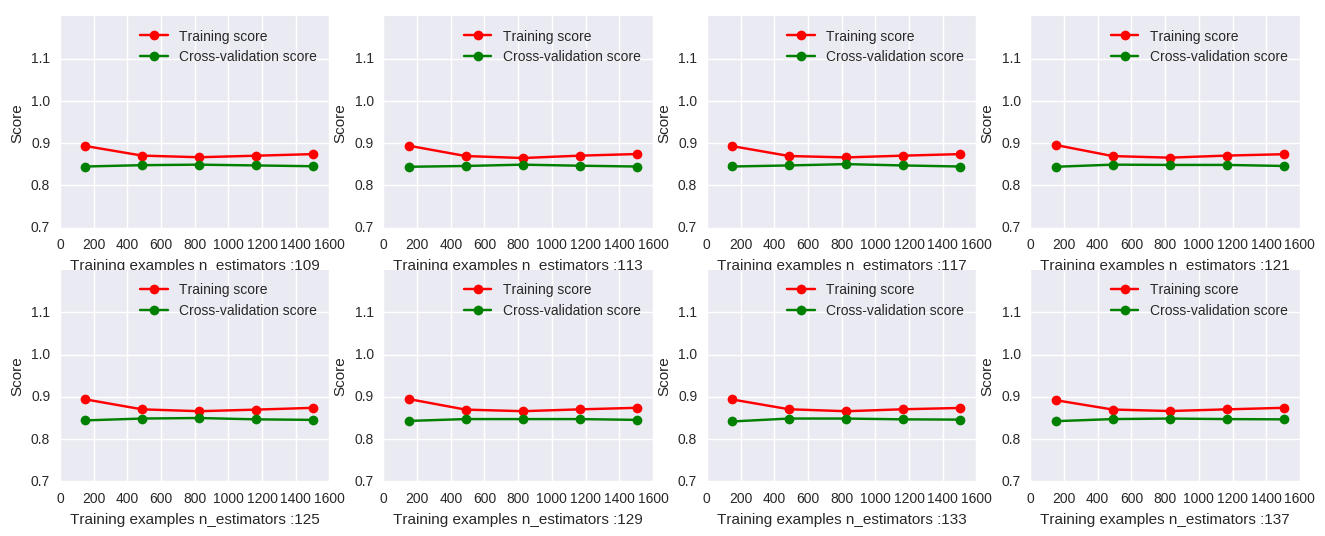

In [133]:
for i,n_estimators in enumerate(range(109, 139, 4)):
    rfc = RFC(max_depth=max_depth_b, max_features=max_features_b, n_estimators=n_estimators, n_jobs=-1, class_weight=class_weights)
    train_sizes, train_scores, test_scores = learning_curve(rfc, x, y, cv=20, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.subplot(2, 4, i+1)
    
    plt.xlim(0, 1600)
    plt.ylim(0.7, 1.2) # trick to better see the labels.

    plt.xlabel("Training examples n_estimators :" + str(n_estimators))
    plt.ylabel("Score")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend()
    
plt.show()
